# Hiring a New Partner at a Consulting Firm

You work for McKeen Sea, a consulting firm. The company wants to promote one of its senior project managers to the position of partner. You've been tasked to analyze and report back the past performance of the two main contendenders in order to inform the hiring process.

Let's start by taking a look at the data you have available and the overall performance of the managers.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from ds_utils.sample_data import get_project_data

data = get_project_data()
data.head()

,Customer,Manager,Project,Service,Performance
74,New,Ben,Small,Old,0.555556
81,New,Ben,Small,Old,0.555556
84,Old,Ben,Small,New,0.888889
47,Old,Aaron,Small,Old,1.000000
72,New,Ben,Small,Old,0.555556


In [2]:
data.Manager.value_counts()

Ben      48
Aaron    48
Name: Manager, dtype: int64

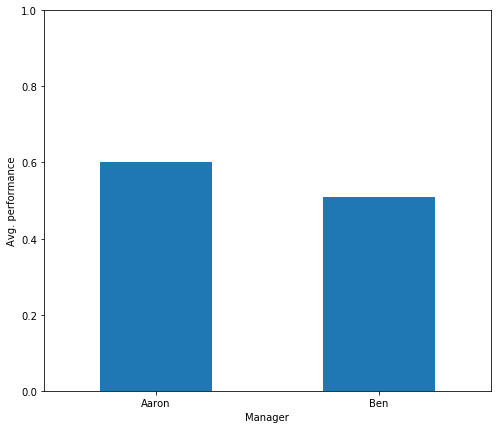

In [3]:
# Some auxiliar functions for plotting
def plot_avg_performance(data, groups=None):
    plot_auxiliar(data, groups, True)
    
def plot_number_of_projects(data, groups=None):
    plot_auxiliar(data, groups, False)

def plot_auxiliar(data, groups, mean=True):
    if groups is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
        if mean:
            data.groupby(['Manager']).Performance.mean().plot(kind='bar', rot=0, ax=ax)
            plt.ylabel('Avg. performance')
            plt.ylim((0, 1))
        else:
            data.groupby(['Manager']).Performance.size().plot(kind='bar', rot=0, ax=ax)
            plt.ylabel('# of projects')
    else:
        grouped = data.groupby(groups)
        rows = int(grouped.ngroups/2)
        fig, axs = plt.subplots(figsize=(16,7*rows), nrows=rows, ncols=2, gridspec_kw=dict(hspace=0.4))
        targets = zip(grouped.groups.keys(), axs.flatten())
        for i, (key, ax) in enumerate(targets):
            if mean:
                grouped.get_group(key).groupby('Manager').Performance.mean().plot(kind='bar', rot=0, ax=ax)
                ax.set_ylabel('Avg. performance')
                ax.set_ylim((0, 1))
            else:
                grouped.get_group(key).groupby('Manager').Performance.size().plot(kind='bar', rot=0, ax=ax)
                ax.set_ylabel('# of projects')
            key_s = []
            if type(key) is not tuple:
                key = (key,)
            for j, elem in enumerate(key):
                key_s.append(elem + ' ' +  groups[j])
            ax.set_title(' | '.join(key_s))

plot_avg_performance(data)

Is this enough information to say that Aaron has performed better than Ben? What happens if we split the data by customer?

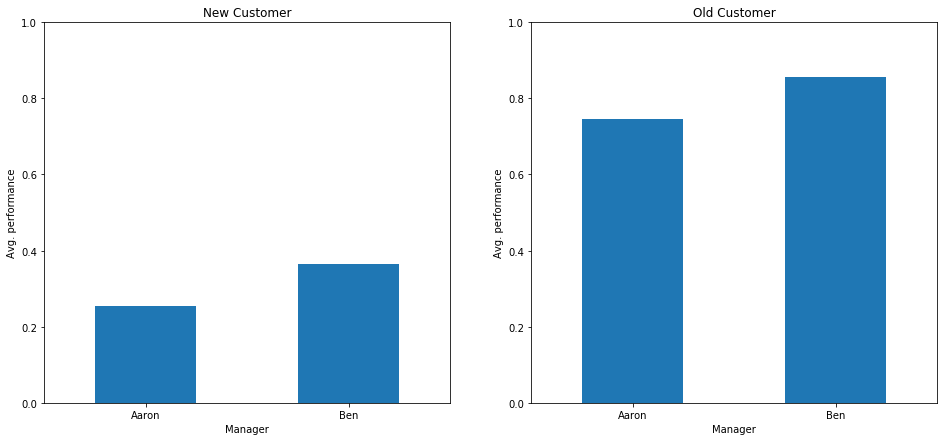

In [4]:
plot_avg_performance(data, groups=['Customer'])

Ben performs better than Aaron, both with new AND old customers! How can this be possible? 

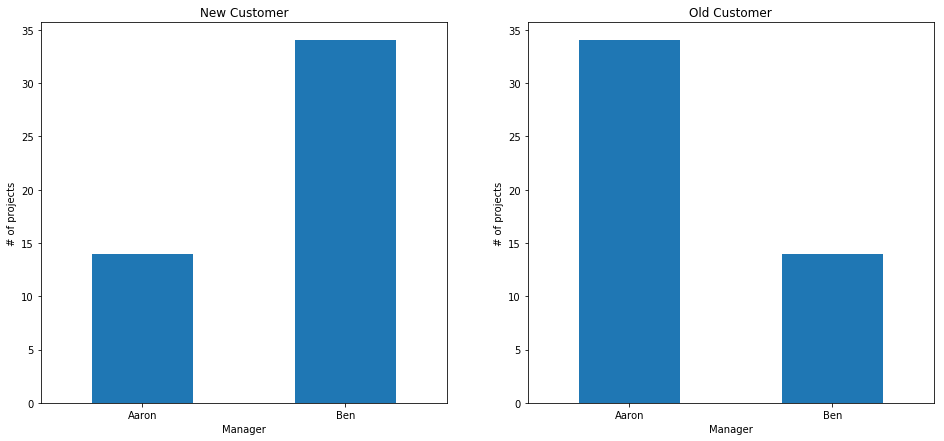

In [5]:
plot_number_of_projects(data, groups=['Customer'])

While Ben has been working mostly with new customers, Aaron has been working mostly with old customers. To the extent that projects with new customers are more difficult, it makes sense for Ben to have a lower average performance. After all, he's been managing more difficult projects. However, once we account for customer type, we can see that Ben had better performance dealing with both types of customers. 

So, who do you think that performed better now? Do you feel more confident with your answer?

Before making a final decision, let's split by project size as well.

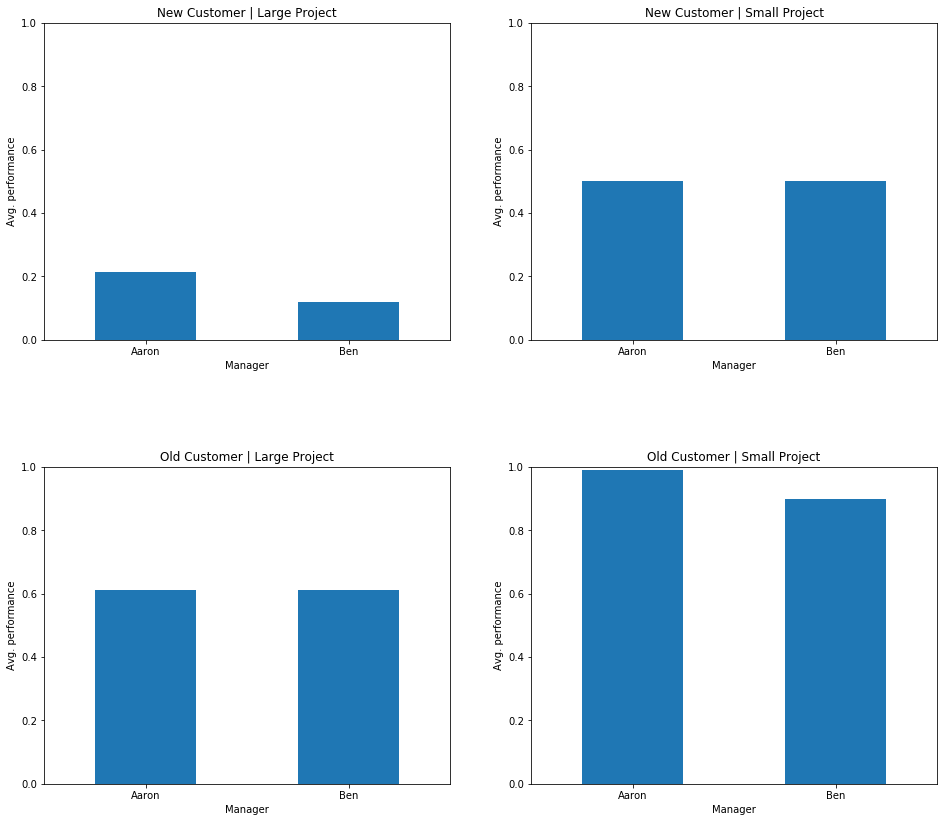

In [6]:
plot_avg_performance(data, groups=['Customer', 'Project'])

The tides have turned again! Aaron now performs the same or better in all categories. Why?

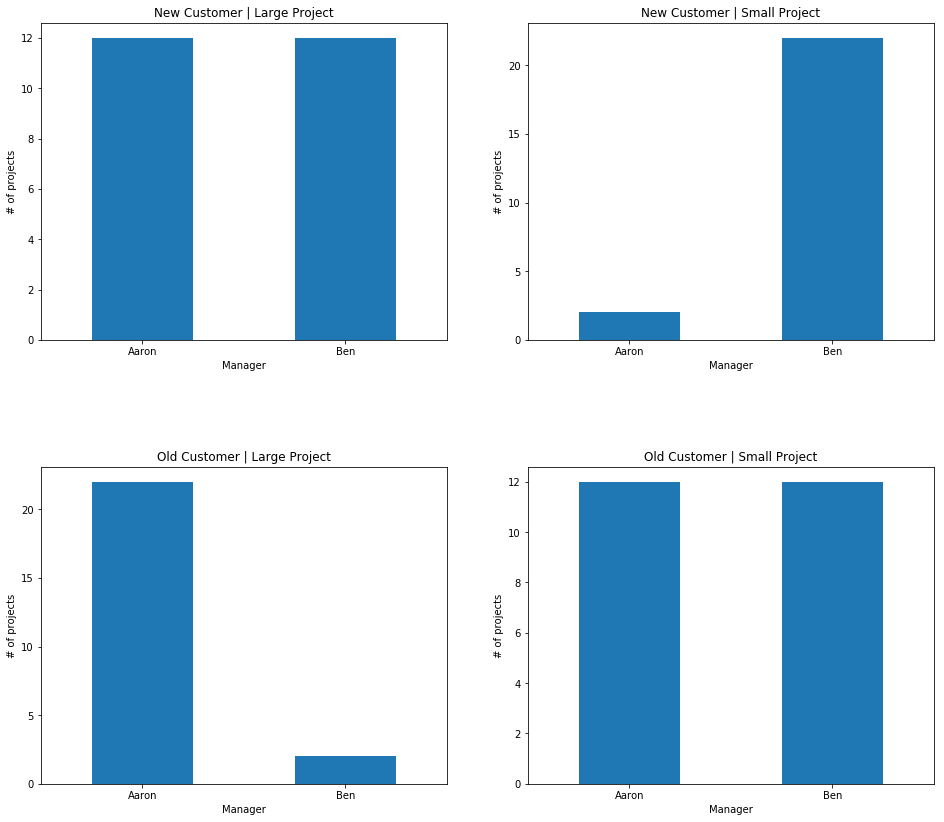

In [7]:
plot_number_of_projects(data, groups=['Customer', 'Project'])

Confounding bias once more. Despite working with older customers, Aaron is also working in larger projects. We can see in earlier graphs that larger projects are more difficult (performance is lower), explaining Aaron's lower performance in other graphs. However, once we account for that in our analysis, we can see that Aaron's average performance is better across all categories.

So... Do you think we can use this data to tell which manager is better (in terms of performance)?

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Not without making additional assumptions about the world! Namely, we would have to assume that there is no other omitted variable influencing both performance and project assignment (such as customer type or project size in the earlier examples). If we cannot make this "no-confounding" assumption, then we cannot be certain of whether the difference in performance is due to the managers or ommited variable(s). Unfortunately, this is an assumption that we cannot test with data! This is why causal inference is so difficult: it is hard to tell whether we are comparing apples with apples.

For our particular example, we would be wrong if we were to make this assumption! There is another variable excluded from our analysis: service type. By including this variable, we can see that both managers perform the same, and that all the differences in performance were driven by factors influencing both performance and project assignment. 

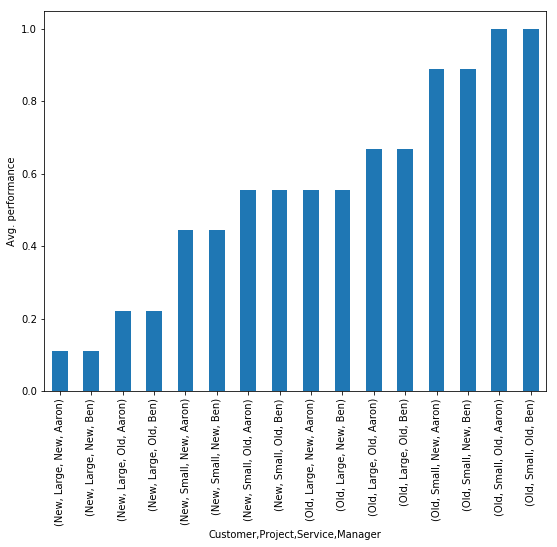

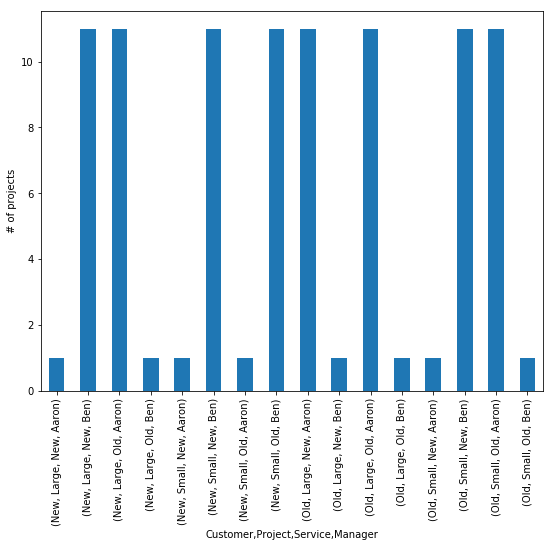

In [8]:
plt.rcParams['figure.figsize'] = [9, 7]
data.groupby(['Customer', 'Project', 'Service', 'Manager']).Performance.mean().plot(kind='bar')
plt.ylabel('Avg. performance')
plt.show()
plt.rcParams['figure.figsize'] = [9, 7]
data.groupby(['Customer', 'Project', 'Service', 'Manager']).Performance.size().plot(kind='bar')
plt.ylabel('# of projects')
plt.show()

This is an example of Simpson's paradox. Simpson’s paradox refers to a phenomena whereby the association between a pair of  variables (X, Y) reverses sign upon conditioning of a third variable, Z, regardless of the value taken by Z. If we partition the data into subpopulations, each representing a specific value of the third variable, the phenomena appears as a sign reversal between the associations measured in the disaggregated subpopulations relative to the aggregated data, which describes the population as a whole. For a more graphical explanation, take a look at the following image:

![Image of Yaktocat](paradox.jpeg)

Going back to our example, let's see what happens with our analysis when we run a linear regression.

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
dummy_data = pd.get_dummies(data=data, drop_first=True)
print(dummy_data.columns)
predictors = ['Manager_Ben']
model.fit(dummy_data[predictors], dummy_data.Performance)
pd.DataFrame([model.coef_], columns=predictors)

Index(['Performance', 'Customer_Old', 'Manager_Ben', 'Project_Small',
       'Service_Old'],
      dtype='object')


,Manager_Ben
0,-0.092593
